In [1]:
import warnings
warnings.filterwarnings("ignore")
import torch
import sys

import tgt
import os
import numpy as np
from tqdm import tqdm
import torchaudio
import librosa
import glob

sys.path.append("/mntcephfs/lab_data/shoinoue/Models/trained_models/vocos/vocos16k_noncausal_tealab/")
from vocos16k_inference import Vocos

sys.path.append("../")
from pyfiles.processsound import trim_audio_and_save

sys.path.append("../../cuhksz-phd/sho_util/pyfiles/")
from pytorch import cuda2numpy, cuda2cpu
from basic import plot_spectrogram
from sound import play_audio

from vocos.feature_extractors import MelSpectrogramFeatures, EncodecFeatures

################################################################################
### WARNING, path does not exist: KALDI_ROOT=/mnt/matylda5/iveselyk/Tools/kaldi-trunk
###          (please add 'export KALDI_ROOT=<your_path>' in your $HOME/.profile)
###          (or run as: KALDI_ROOT=<your_path> python <your_script>.py)
################################################################################



In [8]:
data_dir = "/mntcephfs/lab_data/shoinoue/"
dataset_dir = data_dir + "Dataset/L2-ARCTIC/"
dataset_dir = "/mntcephfs/data/audiow/shoinoue/Dataset/CosyVoice/"
fs = 16000

melgen = MelSpectrogramFeatures(sample_rate=fs)
# speakers = ["ASI", "RRBI", "SVBI", "TNI"]
# speakers.sort()
# thres = {
#     "ASI": 30,
#     "RRBI": 15,
#     "SVBI": 15,
#     "TNI": 15,
# }

speakers = ["AEW", "CLB", "LJM", "LNH", "SLT", "BDL", "EEY", "RMS"]
thres = {spk: 30 for spk in speakers}
thres["EEY"] = 15

def get_mel(path):
    y, sr = torchaudio.load(path)
    if fs!=sr:
        if y.size(0) > 1:  # mix to mono
            y = y.mean(dim=0, keepdim=True)
        y = torchaudio.functional.resample(y, orig_freq=sr, new_freq=fs)
    mel = melgen(y[0])
    return mel

In [9]:
save = True
tempfile = "temp2.wav"
add = "ASI"

for spk in speakers:
    print(spk)
    mel_dir = f"{dataset_dir}{spk}/{add}/mel/"
    os.makedirs(mel_dir, exist_ok=True)
    filenames = glob.glob(dataset_dir + spk + f"/{add}/wav/*")
    filenames.sort()
    for path in tqdm(filenames):
        trim_audio_and_save(path, savepath=tempfile, trim_threshold_in_db=thres[spk])
        mel = get_mel(tempfile)
        savepath = mel_dir + os.path.basename(path)[:-4] + ".npy"
        if save:
            np.save(savepath, mel)

AEW


100%|██████████| 1132/1132 [01:20<00:00, 14.05it/s]


CLB


100%|██████████| 1132/1132 [01:24<00:00, 13.40it/s]


LJM


100%|██████████| 593/593 [00:50<00:00, 11.66it/s]


LNH


100%|██████████| 1132/1132 [01:33<00:00, 12.08it/s]


SLT


100%|██████████| 1132/1132 [01:37<00:00, 11.58it/s]


BDL


100%|██████████| 1132/1132 [01:20<00:00, 14.14it/s]


EEY


100%|██████████| 593/593 [00:41<00:00, 14.42it/s]


RMS


100%|██████████| 1132/1132 [01:24<00:00, 13.46it/s]


- CMU Real

In [6]:
dataset_dir = "/mntcephfs/lab_data/shoinoue/Dataset/CMU-ARCTIC/"
fs = 16000

melgen = MelSpectrogramFeatures(sample_rate=fs)
# speakers = ["ASI", "RRBI", "SVBI", "TNI"]
# speakers.sort()
# thres = {
#     "ASI": 30,
#     "RRBI": 15,
#     "SVBI": 15,
#     "TNI": 15,
# }

speakers = ["AEW", "CLB", "LJM", "LNH", "SLT", "BDL", "EEY", "RMS"]
thres = {spk: 30 for spk in speakers}
thres["EEY"] = 15

In [7]:
save = True
tempfile = "temp2.wav"

for spk in speakers:
    print(spk)
    mel_dir = f"{dataset_dir}{spk}/mel/"
    os.makedirs(mel_dir, exist_ok=True)
    filenames = glob.glob(dataset_dir + spk + f"/wav/*")
    filenames.sort()
    for path in tqdm(filenames):
        trim_audio_and_save(path, savepath=tempfile, trim_threshold_in_db=thres[spk])
        mel = get_mel(tempfile)
        savepath = mel_dir + os.path.basename(path)[:-4] + ".npy"
        if save:
            np.save(savepath, mel)

AEW


100%|██████████| 1132/1132 [00:10<00:00, 108.67it/s]


CLB


100%|██████████| 1132/1132 [00:10<00:00, 104.09it/s]


LJM


100%|██████████| 593/593 [00:05<00:00, 111.53it/s]


LNH


100%|██████████| 1132/1132 [00:10<00:00, 108.12it/s]


SLT


100%|██████████| 1132/1132 [00:15<00:00, 72.67it/s]


BDL


100%|██████████| 1132/1132 [00:14<00:00, 77.50it/s]


EEY


100%|██████████| 593/593 [00:04<00:00, 126.06it/s]


RMS


100%|██████████| 1132/1132 [00:09<00:00, 117.75it/s]


# Normalize

In [43]:
from sklearn.preprocessing import StandardScaler
import numpy as np
import joblib

datasplit = list(np.load("./data_split_ARCTIC.npy", allow_pickle=True))

In [6]:
target_speakers = ["HKK", "TNI"] 

if target_speakers==["HKK", "TNI"]:
    scaler_name = "HKK_TNI"

In [44]:
scaler = StandardScaler()
for spk in target_speakers:
    print(spk)
    mel_dir = f"{dataset_dir}{spk}/mel/"
    files = glob.glob(mel_dir + "*")
    files.sort()
    for path in tqdm(files):
        if os.path.basename(path)[:-4] in datasplit[0]: # sample must be in train
            mel = np.load(path)
            scaler.partial_fit(mel.T)
            
scaler_filename = f"ckpts/scalers/{scaler_name}.save"
joblib.dump(scaler, scaler_filename) 
# a = joblib.load(scaler_filename)

HKK


100%|██████████| 1131/1131 [00:00<00:00, 1592.27it/s]


TNI


100%|██████████| 1131/1131 [00:00<00:00, 1682.23it/s]


['ckpts/scalers/HKK_TNI.save']

(100, 176)


(100, 117)


<AxesSubplot: >

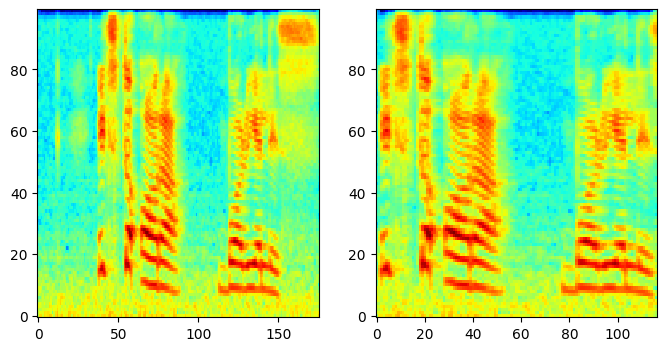

In [46]:
# data_dir = "/mntcephfs/lab_data/shoinoue/"
# dataset_dir = data_dir + "Dataset/L2-ARCTIC/"
# fs = 16000

# melgen = MelSpectrogramFeatures(sample_rate=fs)
# # speakers = [os.path.basename(a) for a in glob.glob(dataset_dir + "*")]
# # speakers.remove("suitcase_corpus")
# speakers = ["ASI", "RRBI", "SVBI", "TNI"]
# speakers.sort()
# spk = speakers[3]
# thres = {
#     "ASI": 30,
#     "RRBI": 15,
#     "SVBI": 15,
#     "TNI": 15,
# }
# sys.path.append("../")
# from pyfiles.processsound import trim_audio_and_save

# import torchaudio
# from vocos.feature_extractors import MelSpectrogramFeatures
# from scipy.io.wavfile import write as write_wav

# fs = 16000
# melgen = MelSpectrogramFeatures(sample_rate=fs)
# def get_mel(path):
#     y, sr = torchaudio.load(path)
#     if fs!=sr:
#         if y.size(0) > 1:  # mix to mono
#             y = y.mean(dim=0, keepdim=True)
#         y = torchaudio.functional.resample(y, orig_freq=sr, new_freq=fs)
#     mel = melgen(y[0])
#     return mel

# filenames = glob.glob(dataset_dir + spk + "/wav/*")
# filenames.sort()
# path = filenames[14]

# fig = plt.figure(figsize=(8, 4))

# x = librosa.load(path, sr=16000)[0]
# write_wav("temp.wav", fs, x)
# mel = np.array(get_mel("temp.wav"))
# print(mel.shape)
# play_audio("temp.wav", 16000)
# plot_spectrogram(mel, fig, (1, 2, 1))

# trim_audio_and_save(path, trim_threshold_in_db=thres[spk])
# # trim_audio_and_save(path, trim_threshold_in_db=30)
# mel = np.array(get_mel("temp.wav"))
# print(mel.shape)
# play_audio("temp.wav", fs)
# plot_spectrogram(mel, fig, (1, 2, 2))